In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import urllib
import sys
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_columns', None)

In [3]:
path = '/Users/yanchao/000_2022/NYU/PUI/Labs-main/Data/ZIPCODE/ZIP_CODE_040114.shp'
zips = gpd.read_file(path)


Sales = pd.read_csv('data/sales/newsales.csv')
Sales.columns = [col.replace('\n','') for col in Sales.columns]
Sales.head(2)

,Unnamed: 0,BOROUGH,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIALUNITS,COMMERCIALUNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,type1crimesum,othercrimesum
0,0,2,1,A1,10457,1,0,1,1842,2048,1901.0,1,600000,2021-01-15,1413,6032
1,1,2,1,A1,10458,1,0,1,1650,1296,1910.0,1,455000,2021-12-23,1368,5038


## DATA processing

In [4]:
#so lets filter the zero values first 
print(Sales.shape)
Sales = Sales[(Sales['ZIP CODE'] > 0) & (Sales['GROSS SQUARE FEET'] > 0\
              ) & (Sales['YEAR BUILT'] > 0) & (Sales['SALE PRICE'] > 0)]

# second check (check the distribution and remove outliers)
Sales = Sales[(Sales['YEAR BUILT'] >= 1850) & (Sales['GROSS SQUARE FEET'] >=300) & (Sales['GROSS SQUARE FEET'] <1e5)
              & (Sales['SALE PRICE'] >= 1e4) & (Sales['SALE PRICE'] <= 5e8)]

print(Sales.shape)

# add price/sqft
Sales['PRICE_SQFT'] = Sales['SALE PRICE'] / Sales['GROSS SQUARE FEET']

# remove outliers
Sales = Sales[(Sales['PRICE_SQFT'] >= Sales['PRICE_SQFT'].quantile(0.01)) & (\
         Sales['PRICE_SQFT'] <= Sales['PRICE_SQFT'].quantile(0.99))] 
print(Sales['PRICE_SQFT'].describe())
print(Sales.shape)

(32967, 16)
(30142, 16)
count    29538.000000
mean       506.689987
std        264.686510
min         43.706294
25%        346.784623
50%        456.413776
75%        598.882855
max       2192.513369
Name: PRICE_SQFT, dtype: float64
(29538, 17)


In [5]:
# add month
Sales['SALE DATE'] = pd.to_datetime(Sales['SALE DATE'])
Sales['MONTH'] = Sales['SALE DATE'].dt.month

# add boro
BoroCode = {3:'BK', 4:'QN', 2:'BX', 5:'SI',1: 'MN'}
Sales['borough'] = Sales.BOROUGH.apply(lambda x: BoroCode[x] if x in BoroCode else np.nan)
# #drop rows which have nan value in any column
# Sales.dropna(inplace=True)

# change format
Sales['ZIP CODE'] = Sales['ZIP CODE'].apply(lambda x: str(x))
# print(Sales.loc[:,'ZIP CODE'][0])

Sales['MONTH'] = Sales['MONTH'].apply(lambda x: str(x))
# print(Sales.loc[:,'MONTH'][0])

Sales['TAX CLASS AT TIME OF SALE'] = Sales['TAX CLASS AT TIME OF SALE'].apply(lambda x: str(x))
# print(Sales.loc[:,'TAX CLASS AT TIME OF SALE'][0])

Sales.head(2)

,Unnamed: 0,BOROUGH,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIALUNITS,COMMERCIALUNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,type1crimesum,othercrimesum,PRICE_SQFT,MONTH,borough
0,0,2,1,A1,10457,1,0,1,1842,2048,1901.0,1,600000,2021-01-15,1413,6032,292.968750,1,BX
1,1,2,1,A1,10458,1,0,1,1650,1296,1910.0,1,455000,2021-12-23,1368,5038,351.080247,12,BX


In [65]:
Sales.shape

(29538, 19)

In [66]:
Sales['SALE PRICE'].sum()

41778869417

## introduction

In [6]:
Sales.PRICE_SQFT.describe()

count    29538.000000
mean       506.689987
std        264.686510
min         43.706294
25%        346.784623
50%        456.413776
75%        598.882855
max       2192.513369
Name: PRICE_SQFT, dtype: float64

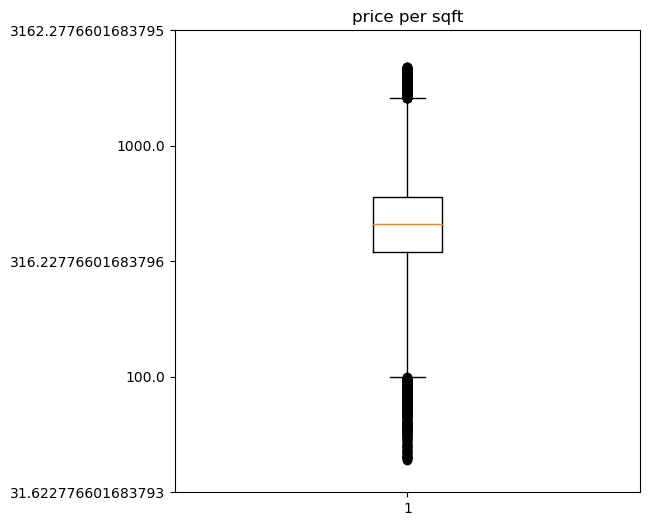

In [16]:
plt.rcParams["figure.figsize"] = (6,6)
ax = plt.subplot(1, 1, 1)
ax.boxplot(np.log10(Sales.PRICE_SQFT), whis=[1, 99]) #box plot of the log trip_speed with 1 and 99 percentiles and the outliers beyond them
ax.set_yticks(np.arange(1.5, 4,0.5))
ax.set_yticklabels(10.0**np.arange(1.5, 4, 0.5))
ax.set_title('price per sqft')
plt.show()

(905410.7560429365, 1075212.5382562787, 112386.35181947277, 280345.45402395504)

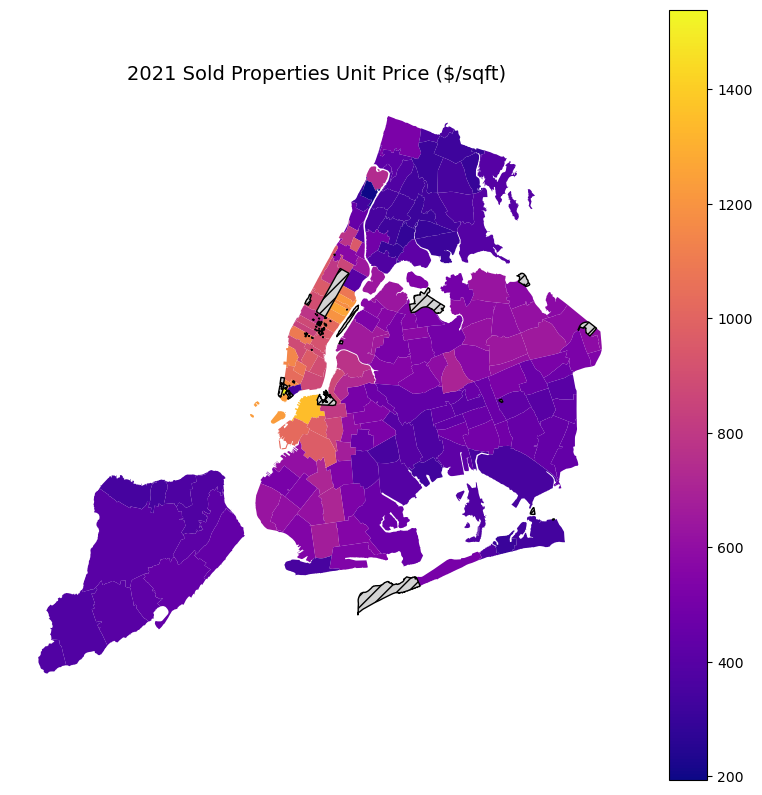

In [63]:
aaaa = Sales.groupby('ZIP CODE',as_index = False).agg({'PRICE_SQFT':'mean'})
zips_s = zips[['geometry','ZIPCODE']].merge(aaaa, left_on = 'ZIPCODE', right_on = 'ZIP CODE', how = 'left')

fig, ax = plt.subplots(figsize=(10,10))
zips_s.plot(ax = ax, column='PRICE_SQFT',colormap='plasma',legend=True,markersize=0.01,figsize=(10,10),missing_kwds={
                "color": "lightgrey", ## what to do with missing values
                "edgecolor": "black",
                "hatch": "///",
                "label": "Missing values",
                },)
# zips_sale[zips_sale.number <= 70].plot(ax = ax, color = 'black')
ax.set_title('2021 Sold Properties Unit Price ($/sqft) ',fontsize=14) 
ax.axis('off')

In [30]:
Sales.head(2)

,Unnamed: 0,BOROUGH,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIALUNITS,COMMERCIALUNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,type1crimesum,othercrimesum,PRICE_SQFT,MONTH,borough
0,0,2,1,A1,10457,1,0,1,1842,2048,1901.0,1,600000,2021-01-15,1413,6032,292.968750,1,BX
1,1,2,1,A1,10458,1,0,1,1650,1296,1910.0,1,455000,2021-12-23,1368,5038,351.080247,12,BX


In [35]:
ppp = Sales.groupby('BUILDING CLASS AT PRESENT',as_index = False).agg({'PRICE_SQFT':'mean'}).sort_values(by = 'PRICE_SQFT',ascending = False)

In [38]:
ppp.head(2)

,BUILDING CLASS AT PRESENT,PRICE_SQFT
53,I2,1795.339252
40,G4,1546.496840


Text(0.5, 0, 'Building Categories')

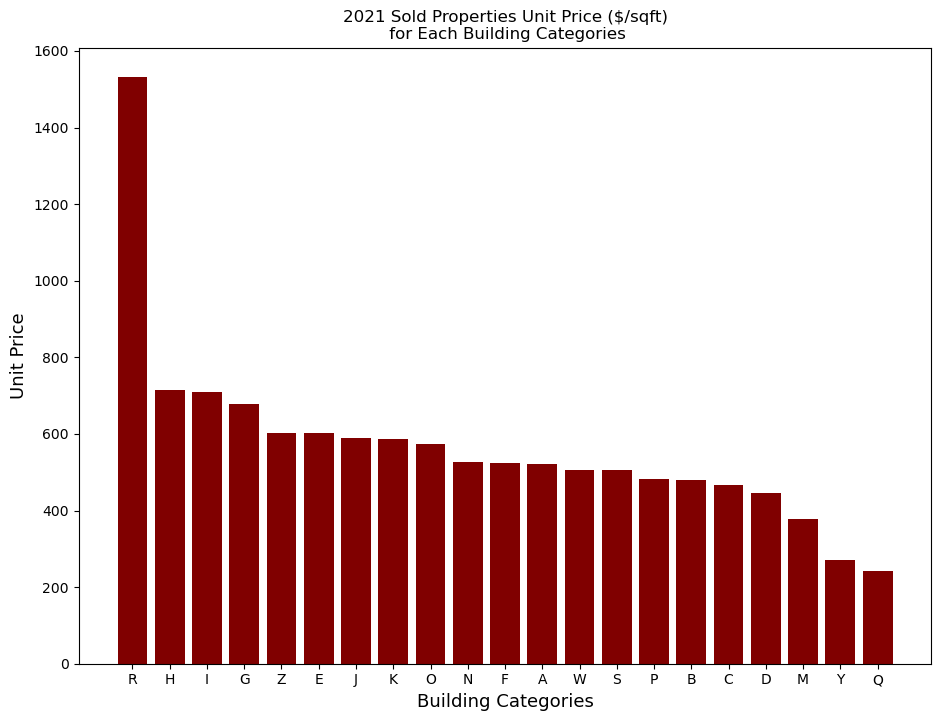

In [71]:
ppp = Sales[['BUILDING CLASS AT PRESENT','PRICE_SQFT']]
ppp['bigCat'] = ppp['BUILDING CLASS AT PRESENT'].apply(lambda x: x[0])
p = ppp.groupby('bigCat',as_index = False).agg({'PRICE_SQFT':'mean'}).sort_values(by = \
                  'PRICE_SQFT',ascending = False)

plt.figure(figsize=(11,8))
plt.bar(p['bigCat'], p['PRICE_SQFT'], color = 'maroon')
plt.title('2021 Sold Properties Unit Price ($/sqft)\n for Each Building Categories')
plt.ylabel('Unit Price',fontsize = 13)
plt.xlabel("Building Categories", fontsize = 13)

## first-time XGBoost

In [72]:
Sales_xgb = Sales[[ 'PRICE_SQFT','TAX CLASS AT PRESENT','BUILDING CLASS AT PRESENT', 'ZIP CODE', 'RESIDENTIALUNITS',\
                   'COMMERCIALUNITS', 'TOTAL UNITS', 'YEAR BUILT', 'TAX CLASS AT TIME OF SALE', 'type1crimesum', \
                   'othercrimesum', 'MONTH','borough']]

for col in Sales_xgb.columns:
    print(col)
    a = Sales.sort_values(by = col, ascending = True).loc[0,col]
    print(a, type(a))

PRICE_SQFT
292.96875 <class 'numpy.float64'>
TAX CLASS AT PRESENT
1 <class 'str'>
BUILDING CLASS AT PRESENT
A1 <class 'str'>
ZIP CODE
10457 <class 'str'>
RESIDENTIALUNITS
1 <class 'numpy.int64'>
COMMERCIALUNITS
0 <class 'numpy.int64'>
TOTAL UNITS
1 <class 'numpy.int64'>
YEAR BUILT
1901.0 <class 'numpy.float64'>
TAX CLASS AT TIME OF SALE
1 <class 'str'>
type1crimesum
1413 <class 'numpy.int64'>
othercrimesum
6032 <class 'numpy.int64'>
MONTH
1 <class 'str'>
borough
BX <class 'str'>


In [6]:
# get dummy variables 
Sales_xgb = pd.get_dummies(data = Sales_xgb, drop_first = False)
Sales_xgb.head(2)

,PRICE_SQFT,RESIDENTIALUNITS,COMMERCIALUNITS,TOTAL UNITS,YEAR BUILT,type1crimesum,othercrimesum,TAX CLASS AT PRESENT_1,TAX CLASS AT PRESENT_2,TAX CLASS AT PRESENT_2A,TAX CLASS AT PRESENT_2B,TAX CLASS AT PRESENT_4,BUILDING CLASS AT PRESENT_A0,BUILDING CLASS AT PRESENT_A1,BUILDING CLASS AT PRESENT_A2,BUILDING CLASS AT PRESENT_A3,BUILDING CLASS AT PRESENT_A4,BUILDING CLASS AT PRESENT_A5,BUILDING CLASS AT PRESENT_A6,BUILDING CLASS AT PRESENT_A7,BUILDING CLASS AT PRESENT_A9,BUILDING CLASS AT PRESENT_B1,BUILDING CLASS AT PRESENT_B2,BUILDING CLASS AT PRESENT_B3,BUILDING CLASS AT PRESENT_B9,BUILDING CLASS AT PRESENT_C0,BUILDING CLASS AT PRESENT_C1,BUILDING CLASS AT PRESENT_C2,BUILDING CLASS AT PRESENT_C3,BUILDING CLASS AT PRESENT_C4,BUILDING CLASS AT PRESENT_C5,BUILDING CLASS AT PRESENT_C7,BUILDING CLASS AT PRESENT_C9,BUILDING CLASS AT PRESENT_D1,BUILDING CLASS AT PRESENT_D2,BUILDING CLASS AT PRESENT_D3,BUILDING CLASS AT PRESENT_D5,BUILDING CLASS AT PRESENT_D6,BUILDING CLASS AT PRESENT_D7,BUILDING CLASS AT PRESENT_D9,BUILDING CLASS AT PRESENT_E1,BUILDING CLASS AT PRESENT_E2,BUILDING CLASS AT PRESENT_E7,BUILDING CLASS AT PRESENT_E9,BUILDING CLASS AT PRESENT_F1,BUILDING CLASS AT PRESENT_F2,BUILDING CLASS AT PRESENT_F4,BUILDING CLASS AT PRESENT_F5,BUILDING CLASS AT PRESENT_F9,BUILDING CLASS AT PRESENT_G1,BUILDING CLASS AT PRESENT_G2,BUILDING CLASS AT PRESENT_G3,BUILDING CLASS AT PRESENT_G4,BUILDING CLASS AT PRESENT_G8,BUILDING CLASS AT PRESENT_G9,BUILDING CLASS AT PRESENT_GU,BUILDING CLASS AT PRESENT_GW,BUILDING CLASS AT PRESENT_H2,BUILDING CLASS AT PRESENT_H3,BUILDING CLASS AT PRESENT_H6,BUILDING CLASS AT PRESENT_H8,BUILDING CLASS AT PRESENT_H9,BUILDING CLASS AT PRESENT_HB,BUILDING CLASS AT PRESENT_HS,BUILDING CLASS AT PRESENT_I1,BUILDING CLASS AT PRESENT_I2,BUILDING CLASS AT PRESENT_I5,BUILDING CLASS AT PRESENT_I6,BUILDING CLASS AT PRESENT_I7,BUILDING CLASS AT PRESENT_I9,BUILDING CLASS AT PRESENT_J1,BUILDING CLASS AT PRESENT_J6,BUILDING CLASS AT PRESENT_J8,BUILDING CLASS AT PRESENT_J9,BUILDING CLASS AT PRESENT_K1,BUILDING CLASS AT PRESENT_K2,BUILDING CLASS AT PRESENT_K3,BUILDING CLASS AT PRESENT_K4,BUILDING CLASS AT PRESENT_K5,BUILDING CLASS AT PRESENT_K6,BUILDING CLASS AT PRESENT_K7,BUILDING CLASS AT PRESENT_K8,BUILDING CLASS AT PRESENT_K9,BUILDING CLASS AT PRESENT_M1,BUILDING CLASS AT PRESENT_M2,BUILDING CLASS AT PRESENT_M3,BUILDING CLASS AT PRESENT_M4,BUILDING CLASS AT PRESENT_M9,BUILDING CLASS AT PRESENT_N2,BUILDING CLASS AT PRESENT_N9,BUILDING CLASS AT PRESENT_O1,BUILDING CLASS AT PRESENT_O2,BUILDING CLASS AT PRESENT_O3,BUILDING CLASS AT PRESENT_O5,BUILDING CLASS AT PRESENT_O6,BUILDING CLASS AT PRESENT_O7,BUILDING CLASS AT PRESENT_O8,BUILDING CLASS AT PRESENT_O9,BUILDING CLASS AT PRESENT_P2,BUILDING CLASS AT PRESENT_P4,BUILDING CLASS AT PRESENT_P5,BUILDING CLASS AT PRESENT_P6,BUILDING CLASS AT PRESENT_P9,BUILDING CLASS AT PRESENT_Q9,BUILDING CLASS AT PRESENT_RR,BUILDING CLASS AT PRESENT_S0,BUILDING CLASS AT PRESENT_S1,BUILDING CLASS AT PRESENT_S2,BUILDING CLASS AT PRESENT_S3,BUILDING CLASS AT PRESENT_S4,BUILDING CLASS AT PRESENT_S5,BUILDING CLASS AT PRESENT_S9,BUILDING CLASS AT PRESENT_W1,BUILDING CLASS AT PRESENT_W2,BUILDING CLASS AT PRESENT_W8,BUILDING CLASS AT PRESENT_W9,BUILDING CLASS AT PRESENT_Y3,BUILDING CLASS AT PRESENT_Z3,BUILDING CLASS AT PRESENT_Z9,ZIP CODE_10001,ZIP CODE_10002,ZIP CODE_10003,ZIP CODE_10004,ZIP CODE_10006,ZIP CODE_10007,ZIP CODE_10009,ZIP CODE_10010,ZIP CODE_10011,ZIP CODE_10012,ZIP CODE_10013,ZIP CODE_10014,ZIP CODE_10016,ZIP CODE_10017,ZIP CODE_10018,ZIP CODE_10019,ZIP CODE_10021,ZIP CODE_10022,ZIP CODE_10023,ZIP CODE_10024,ZIP CODE_10025,ZIP CODE_10026,ZIP CODE_10027,ZIP CODE_10028,ZIP CODE_10029,ZIP CODE_10030,ZIP CODE_10031,ZIP CODE_10032,ZIP CODE_10033,ZIP CODE_10034,ZIP CODE_10035,ZIP CODE_10036,ZIP CODE_10037,ZIP CODE_10038,ZIP CODE_10039,ZIP CODE_10040,ZIP CODE_10065,ZIP CODE_10075,ZIP CODE_10128,ZIP CODE_10301,ZIP CODE_10302,ZIP CODE_10303,ZIP CODE_10304,ZIP CODE_10305,ZIP CODE_10306,ZIP CODE_

In [7]:
Sales_xgb.isnull().values.any()

False

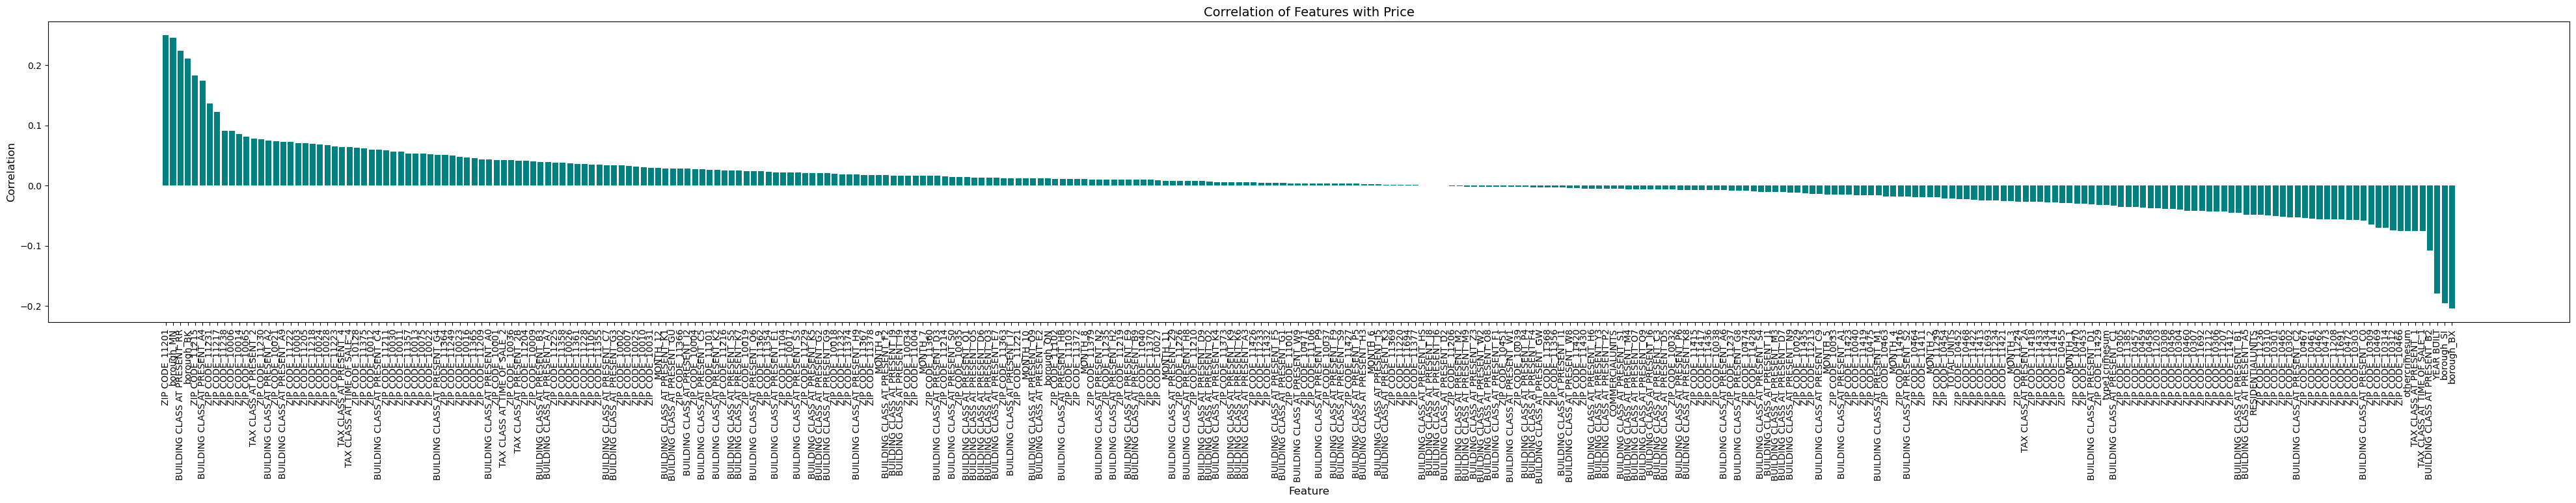

In [8]:
# check correlation
cor=Sales_xgb.corr()['PRICE_SQFT'].sort_values(ascending=False).drop('PRICE_SQFT')

plt.figure(figsize=(50,6))
plt.bar(x=list(cor.index), height=list(cor.values), color='teal')
plt.xticks(rotation=90)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.title('Correlation of Features with Price', fontsize=14)
plt.show()

In [9]:
# fit model with all parameters
# split into test and train with ratio of 0.7,0.3

# split data into X and y
X = Sales_xgb.iloc[:,1:]
y = Sales_xgb.iloc[:,0]

## split data into training and test dataset
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=1024)

## fit model with training data
xgbr= xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, verbosity=0, max_depth=7)
print(xgbr)

xgbr.fit(X_train, y_train)
 
score = xgbr.score(X_train, y_train)   
print("Training score: ", score) 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
Training score:  0.6592242073445098


In [10]:
# cross validataion 
# scores = cross_val_score(xgbr, X_train, y_train, cv=5)
# print("Mean cross-validation score: %.2f" % scores.mean())

# kfold = KFold(n_splits=10, shuffle=True)
# kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )
# print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
 
y_pred = xgbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r_2 = metrics.r2_score(y_test,y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))
print('R2 Score_Linear Regression: %.2f'% r_2)

Mean cross-validation score: 0.47
K-fold CV average score: 0.47
MSE: 36203.35
RMSE: 190.27
R2 Score_Linear Regression: 0.49


Text(0.5, 0, 'Xgboost Feature Importance')

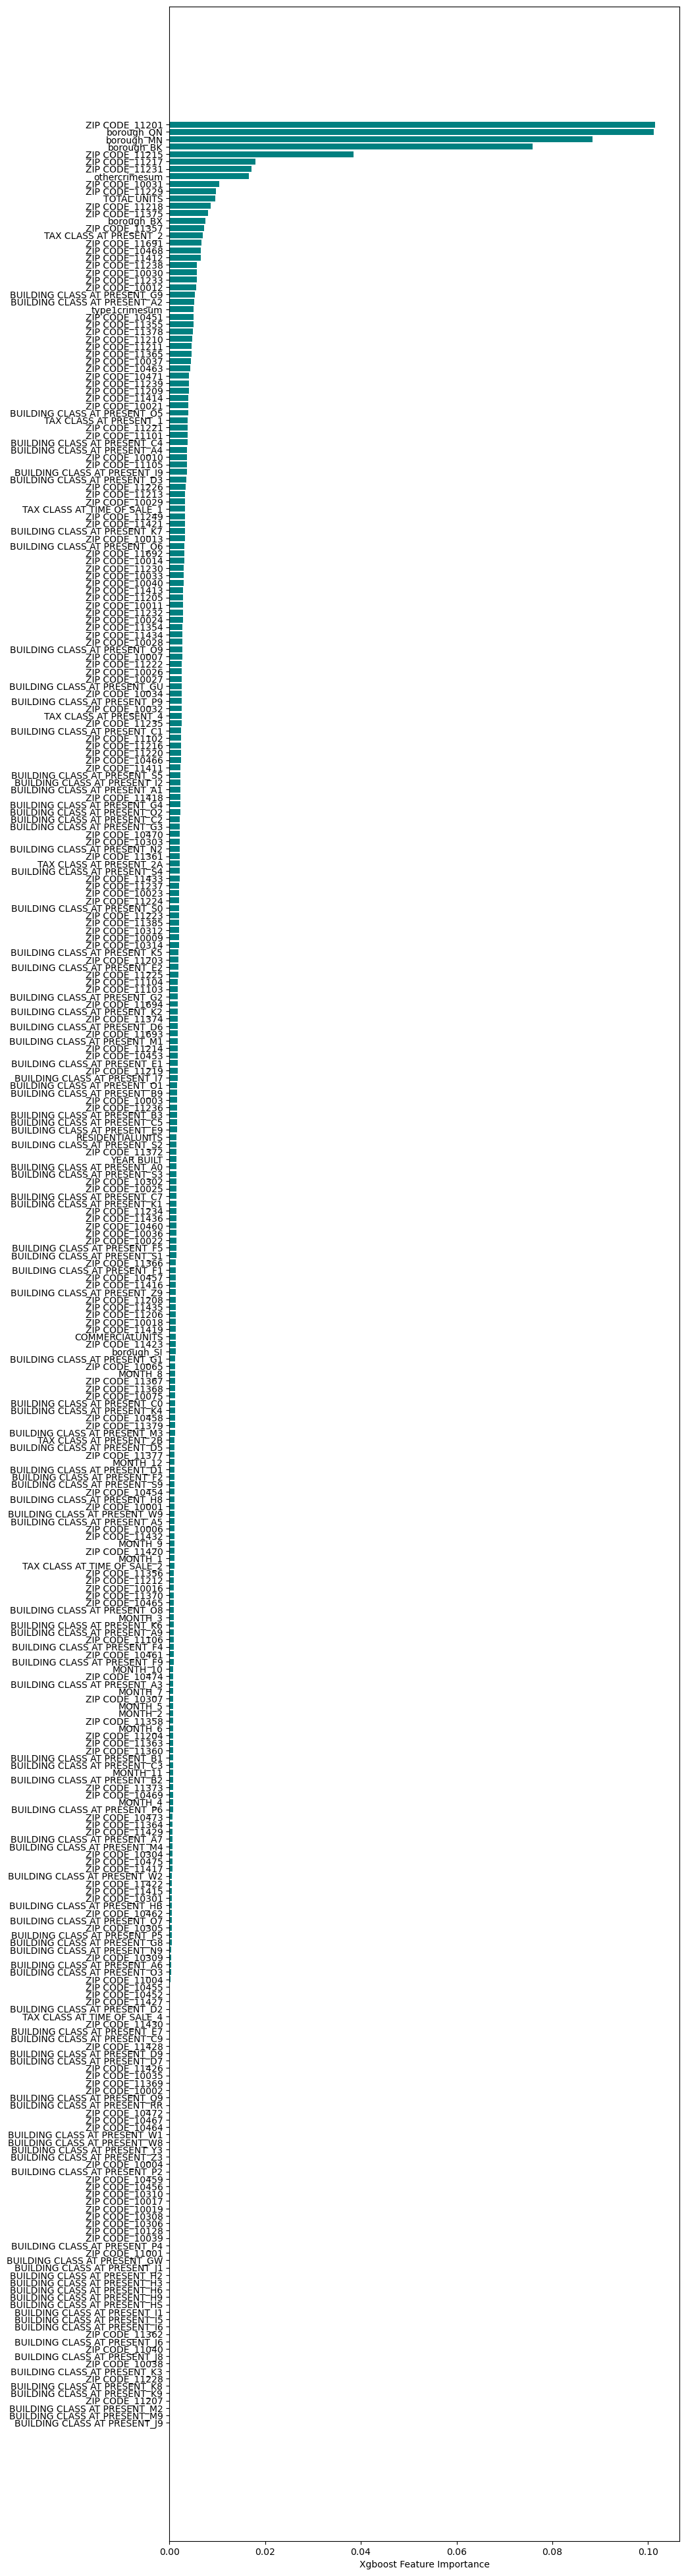

In [11]:
## feature importance
# print(xgbr.feature_importances_)

## plot
# plt.bar(range(len(xgbr.feature_importances_)), xgbr.feature_importances_)
# plt.show()
plt.figure(figsize=(10,50))
sorted_idx = xgbr.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], xgbr.feature_importances_[sorted_idx], color = 'teal')
plt.xlabel("Xgboost Feature Importance")

Text(0.5, 0, 'Xgboost Feature Importance (TOP 20)')

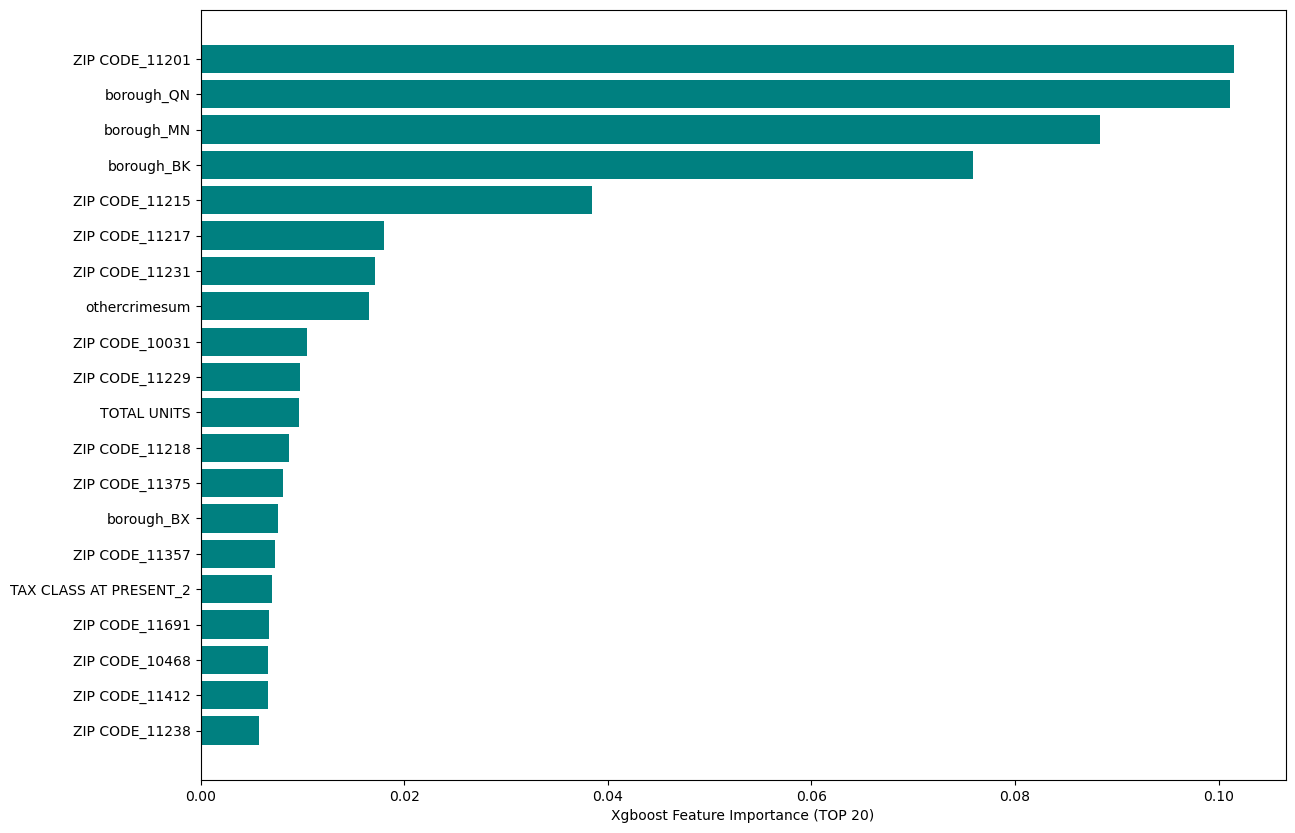

In [34]:
plt.figure(figsize=(14,10))
sorted_idx = xgbr.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx][292:], xgbr.feature_importances_[sorted_idx][292:], color = 'teal')
plt.xlabel("Xgboost Feature Importance (TOP 20)")

In [ ]:
# # find the feature of greatest importance
# idx = list(range(len(X.columns)))
# lst = list(X.columns)
# dic = {v:k for v, k in enumerate(lst)}
# ft = pd.DataFrame(data = dic, index = [0]).T
# ft.rename(columns = {0:'column'}, inplace = True)

# dic2 = {v:k for v, k in enumerate(xgbr.feature_importances_)}
# ft2 = pd.DataFrame(data = dic2, index = [0]).T
# ft2.rename(columns = {0:'value'}, inplace = True)

# ft = ft.merge(ft2, left_index = True, right_index= True, how = 'inner')

# # features of the most importance
# ft.sort_values(by = 'value', ascending = False).head(15)

# # features of least importance
# ft.sort_values(by = 'value', ascending = True).head(15)

#top = ft.sort_values(by = 'value', ascending = False).head(15)
# plt.figure(figsize=(12,6))
# plt.bar(top.column, height=top.value, color='teal')
# plt.xticks(rotation=90)
# plt.xlabel('feature', fontsize=12)
# plt.ylabel('f-score in xgbr', fontsize=12)
# plt.title('Feature importance (Top 15)', fontsize=16)
# plt.show()

## feature selection

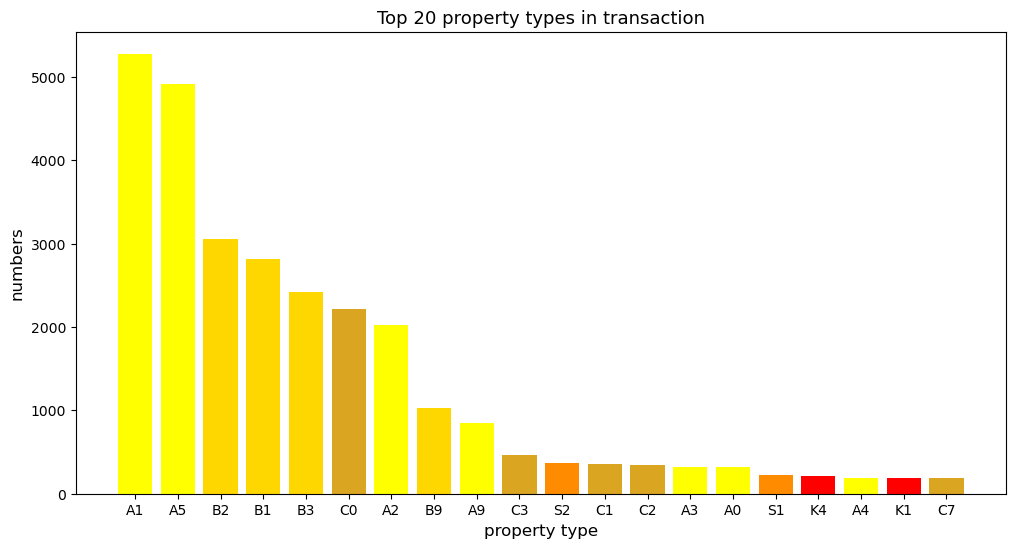

In [73]:
### classify building types
a = Sales[['BUILDING CLASS AT PRESENT','SALE PRICE']].groupby(['BUILDING CLASS AT PRESENT'], as_index = False).count(\
       ).rename(columns = {'SALE PRICE':'number'}).sort_values(by = 'number', ascending = False)
a['largeCat'] = a['BUILDING CLASS AT PRESENT'].apply(lambda x: x[0])

b = a.head(20)
plt.figure(figsize=(12,6))
color_map = {'A':'yellow','B':'gold','C':'goldenrod','S':'darkorange','K':'red'}
color_list = list(b.largeCat.map(color_map))

plt.bar(b['BUILDING CLASS AT PRESENT'], height=b.number, color=color_list)
# b.plot(kind = 'bar',color = color_list)
# plt.xticks(rotation=90)
plt.xlabel('property type', fontsize=12)
plt.ylabel('numbers', fontsize=12)
plt.title('Top 20 property types in transaction', fontsize=13)
plt.show()

In [74]:
# only predict the top 20 property types


keep_btypes = list(b['BUILDING CLASS AT PRESENT'].unique())
print(len(keep_btypes))
Sales_filter = Sales[Sales['BUILDING CLASS AT PRESENT'].isin(keep_btypes)] # remove the features that has no importance.

print(Sales_filter.shape)

# top 20 accounts for 94% of transaction.
b.number.sum()/a.number.sum()

20
(27790, 19)


0.9408219920102918

In [75]:
# ## mark the zip code that are of importance
# top_zip = ['11201','11215','11217','11218','11231']
# bot_zip = ['11367','11369','11370','11377','11004']
# Sales_filter['isTopZip'] = Sales_filter['ZIP CODE'].apply(lambda x:'Y' if x in top_zip else 'N')
# Sales_filter['isBotZip'] = Sales_filter['ZIP CODE'].apply(lambda x:'Y' if x in bot_zip else 'N')

### check buildings sold per zipcode:
z = Sales.groupby('ZIP CODE',as_index = False).agg({'SALE PRICE':'count'}).rename(\
                   columns = {'SALE PRICE':'number'}).sort_values(by = 'number', ascending = False)
# select the zipcode that sold more than 70
z[z.number > 70].number.sum()/z.number.sum()

0.9418376328796804

In [38]:
path = '/Users/yanchao/000_2022/NYU/PUI/Labs-main/Data/ZIPCODE/ZIP_CODE_040114.shp'
zips = gpd.read_file(path)

Text(0.5, 1.0, 'Distribution of sold properties in NYC (2021)')

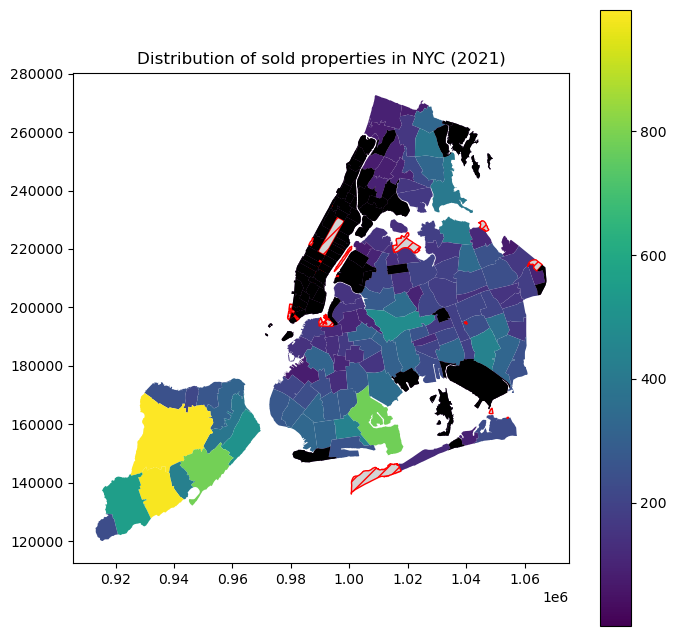

In [39]:
zips_sale = zips[['geometry','ZIPCODE']].merge(z, left_on = 'ZIPCODE', right_on = 'ZIP CODE', how = 'outer')

fig, ax = plt.subplots(figsize=(8,8))
zips_sale.plot(ax = ax, column='number',colormap='viridis',legend=True,markersize=0.01,figsize=(10,10),missing_kwds={
                "color": "lightgrey", ## what to do with missing values
                "edgecolor": "red",
                "hatch": "///",
                "label": "Missing values",
                },)
zips_sale[zips_sale.number <= 70].plot(ax = ax, color = 'black')
ax.set_title('Distribution of sold properties in NYC (2021)',fontsize=12) 

In [76]:
# get dummy variables 
Sales_xgb2 = Sales_filter[[ 'PRICE_SQFT','type1crimesum', 'othercrimesum', 'TAX CLASS AT PRESENT','BUILDING CLASS AT PRESENT', 'ZIP CODE','RESIDENTIALUNITS',
       'COMMERCIALUNITS', 'TOTAL UNITS',  'TAX CLASS AT TIME OF SALE','MONTH','borough']]
Sales_xgb2 = pd.get_dummies(data = Sales_xgb2, drop_first = False)
print(Sales_xgb2.shape)

(27790, 223)


In [77]:
Sales_filter.groupby('BUILDING CLASS AT PRESENT', as_index = False).agg({'PRICE_SQFT':'mean','ZIP CODE':'count'}).sort_values(by = 'PRICE_SQFT')

,BUILDING CLASS AT PRESENT,PRICE_SQFT,ZIP CODE
13,C2,378.925637,346
8,B2,422.666263,3055
12,C1,427.170350,351
11,C0,452.317880,2213
19,S2,463.416731,373
7,B1,469.777558,2812
5,A5,478.355748,4920
18,S1,490.236537,228
14,C3,494.339080,470
1,A1,498.200302,5280


In [ ]:
# a = Sales[['BUILDING CLASS AT PRESENT','SALE PRICE']].groupby(['BUILDING CLASS AT PRESENT'], as_index = False).count(\
#        ).rename(columns = {'SALE PRICE':'number'}).sort_values(by = 'number', ascending = False)
# a['largeCat'] = a['BUILDING CLASS AT PRESENT'].apply(lambda x: x[0])

# b = a.head(20)
# plt.figure(figsize=(12,6))
# color_map = {'A':'yellow','B':'gold','C':'goldenrod','S':'darkorange','K':'red'}
# color_list = list(b.largeCat.map(color_map))

# plt.bar(b['BUILDING CLASS AT PRESENT'], height=b.number, color=color_list)
# # b.plot(kind = 'bar',color = color_list)
# # plt.xticks(rotation=90)
# plt.xlabel('feature', fontsize=12)
# plt.ylabel('property type', fontsize=12)
# plt.title('Top 20 property types in transaction', fontsize=13)
# plt.show()

In [ ]:
# select features

# # list(xgbr.feature_importances_[sorted_idx])[60:]
# columns for feature importance > 0 
keep_features = list(X.columns[sorted_idx])[60:] # according to the first time training

# select zip code 
remove_zip = list(z[z.number <= 70]['ZIP CODE'].unique())
remove_zip_features = [ 'ZIP CODE_' + x for x in remove_zip]

# list(set(keep_features).intersection(zip_features))
keeps = [x for x in keep_features if x not in remove_zip_features]
keeps.insert(0, 'PRICE_SQFT')



Sales_xgb2 = Sales_xgb2[Sales_xgb2.columns.intersection(keeps)]
print(Sales_xgb2.shape)

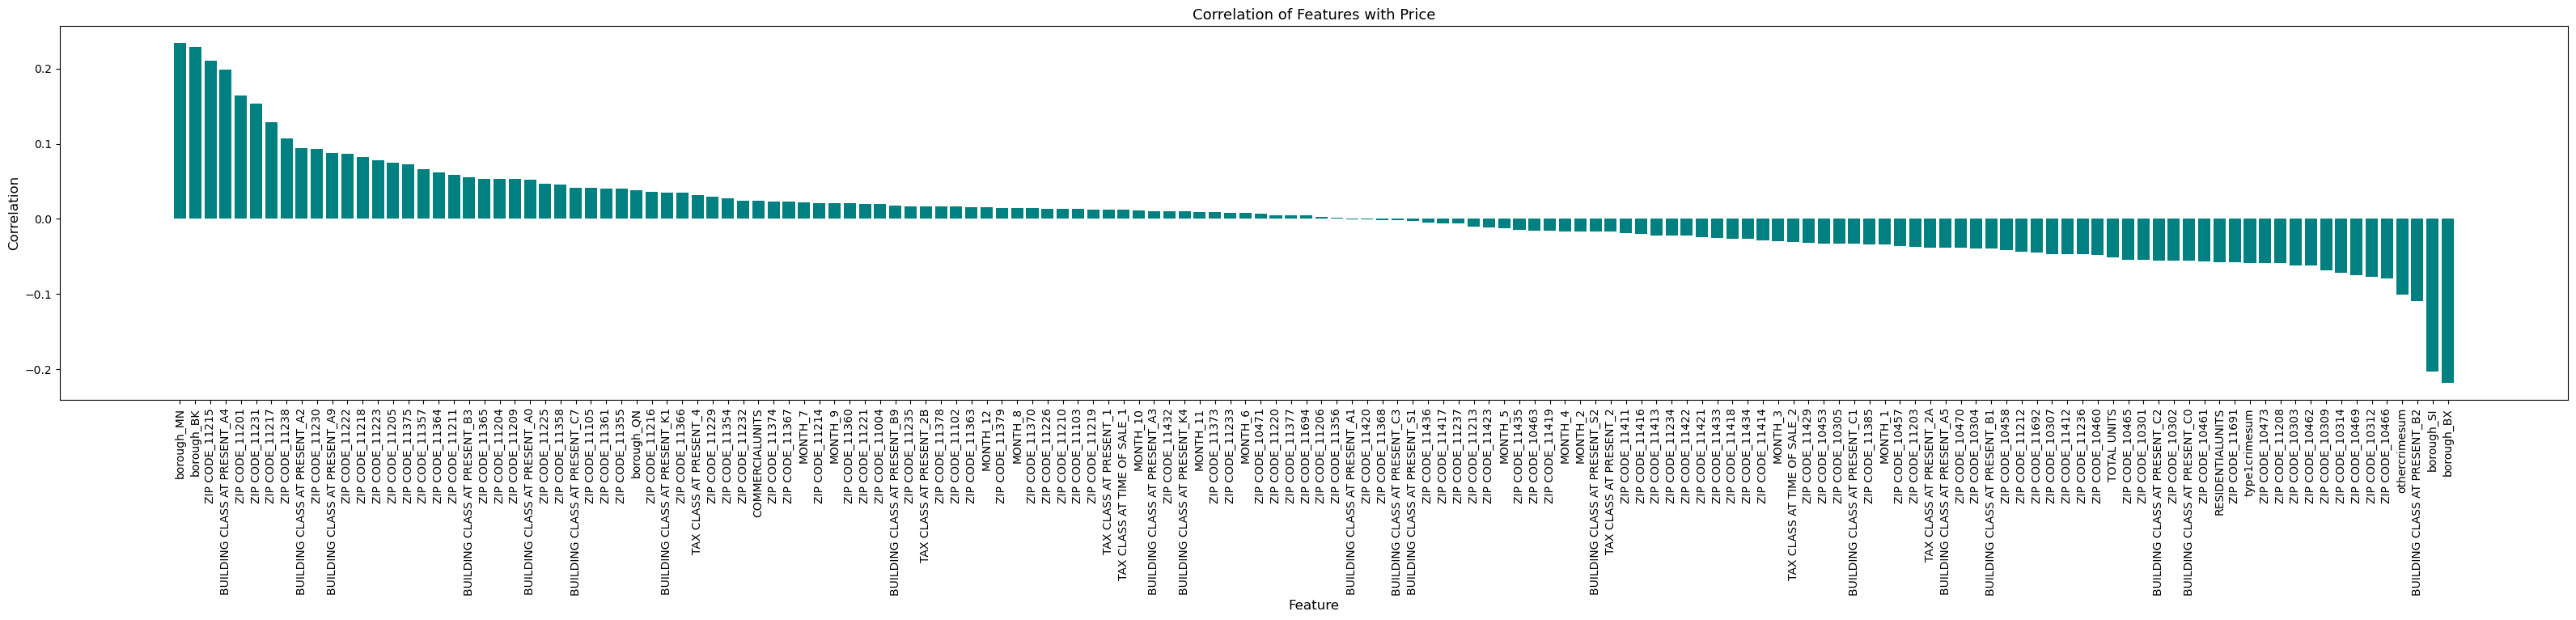

In [42]:
# check correlation
cor=Sales_xgb2.corr()['PRICE_SQFT'].sort_values(ascending=False).drop('PRICE_SQFT')
plt.figure(figsize=(40,6))
plt.bar(x=list(cor.index), height=list(cor.values), color='teal')
plt.xticks(rotation=90)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.title('Correlation of Features with Price', fontsize=13)
plt.show()

In [43]:
# import xgboost as xgb
# from xgboost import XGBClassifier
# from sklearn import metrics
# from sklearn.model_selection import train_test_split
# load data

# split data into X and y
X2 = Sales_xgb2.iloc[:,1:]
y2 = Sales_xgb2.iloc[:,0]

## split data into training and test dataset
X_train2,X_test2,y_train2,y_test2=train_test_split(X2, y2, test_size=0.3, random_state=1024)
# print(X_train.head(2))


# fit model with training data
xgbr2 = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, verbosity=0, max_depth=7)
print(xgbr2)

xgbr2.fit(X_train2, y_train2)
 
y_pred2 = xgbr2.predict(X_test2)
mse2 = mean_squared_error(y_test2, y_pred2)
r_22 = metrics.r2_score(y_test2,y_pred2)
print("MSE: %.2f" % mse2)
print("RMSE: %.2f" % (mse2**(1/2.0)))
print('R2 Score_Linear Regression: %.2f'% r_22)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
MSE: 32195.85
RMSE: 179.43
R2 Score_Linear Regression: 0.46


In [79]:
Sales_filter

,Unnamed: 0,BOROUGH,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIALUNITS,COMMERCIALUNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,type1crimesum,othercrimesum,PRICE_SQFT,MONTH,borough
0,0,2,1,A1,10457,1,0,1,1842,2048,1901.0,1,600000,2021-01-15,1413,6032,292.968750,1,BX
1,1,2,1,A1,10458,1,0,1,1650,1296,1910.0,1,455000,2021-12-23,1368,5038,351.080247,12,BX
2,2,2,1,A1,10457,1,0,1,2340,1516,1910.0,1,580000,2021-07-22,1413,6032,382.585752,7,BX
3,3,2,1,A9,10458,1,0,1,925,1188,1901.0,1,251600,2021-08-17,1368,5038,211.784512,8,BX
4,4,2,1,B1,10457,2,0,2,2000,2400,1993.0,1,655000,2021-04-09,1413,6032,272.916667,4,BX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32959,32959,5,1,B9,10309,2,0,2,2540,2007,1998.0,1,675000,2021-08-27,132,824,336.322870,8,SI
32960,32960,5,1,B9,10309,2,0,2,2438,2178,1999.0,1,219973,2021-02-12,132,824,100.997704,2,SI
32961,32961,5,1,B9,10309,2,0,2,2645,2250,2001.0,1,550000,2021-02-03,132,824,244.444444,2,SI
32962,32962,5,1,B9,10309,2,0,2,2562,2565,2001.0,1,638500,2021-03-26,132,824,248.927875,3,SI


In [ ]:
## linear regression

In [83]:
lma = Sales_filter.groupby(by = ['ZIP CODE'], as_index = False).agg({'PRICE_SQFT':'mean'\
                                                              }).sort_values(by = ['PRICE_SQFT'], ascending = False)
lma

,ZIP CODE,PRICE_SQFT
34,10065,1429.166547
9,10014,1411.788737
16,10023,1327.141348
3,10007,1303.928568
15,10022,1260.408261
...,...,...
58,10460,298.949486
57,10459,277.745873
72,10474,202.739066
33,10040,172.064327


In [94]:
lma.PRICE_SQFT.quantile([0.1,0.25,0.5,0.75,0.9])

0.10    325.979661
0.25    399.239481
0.50    519.857774
0.75    660.216746
0.90    973.897672
Name: PRICE_SQFT, dtype: float64

In [102]:
Sales_filter.head(3)

,Unnamed: 0,BOROUGH,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIALUNITS,COMMERCIALUNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,type1crimesum,othercrimesum,PRICE_SQFT,MONTH,borough
0,0,2,1,A1,10457,1,0,1,1842,2048,1901.0,1,600000,2021-01-15,1413,6032,292.968750,1,BX
1,1,2,1,A1,10458,1,0,1,1650,1296,1910.0,1,455000,2021-12-23,1368,5038,351.080247,12,BX
2,2,2,1,A1,10457,1,0,1,2340,1516,1910.0,1,580000,2021-07-22,1413,6032,382.585752,7,BX


In [107]:
topZip18 = list(lma.head(18)['ZIP CODE'].unique()) # higher 10 percentile
botZip18 = list(lma.tail(18)['ZIP CODE'].unique()) # lower 10 percentile

Sales_filter['isTopZip'] = Sales_filter['ZIP CODE'].apply(lambda x:'Y' if x in topZip18 else 'N')
Sales_filter['isBotZip'] = Sales_filter['ZIP CODE'].apply(lambda x:'Y' if x in botZip18 else 'N')

In [104]:
sdic = {1:'S1',2:'S1',3:'S1',4:'S2',5:'S2',6:'S2',7:'S3',8:'S3',9:'S3',10:'S4',11:'S4',12:'S4'}
Sales_filter.MONTH = Sales_filter.MONTH.astype(int)
Sales_filter['SEASON'] = Sales_filter['MONTH'].apply(lambda x: sdic[x])
Sales_filter.MONTH = Sales_filter.MONTH.astype(str)


ylr = Sales_filter.groupby(by = ['YEAR BUILT'], as_index= False).agg({'PRICE_SQFT':'mean'\
                             }).sort_values(by = 'PRICE_SQFT',ascending = False)
top15yr = list(ylr.head(15)['YEAR BUILT'].unique())
bot15yr = list(ylr.tail(15)['YEAR BUILT'].unique())

Sales_filter['isTopYr'] = Sales_filter['YEAR BUILT'].apply(lambda x:'Y' if x in top15yr else 'N')
Sales_filter['isBotYr'] = Sales_filter['YEAR BUILT'].apply(lambda x:'Y' if x in bot15yr else 'N')

In [105]:
Sales_filter['bigCat'] = Sales_filter['BUILDING CLASS AT PRESENT'].apply(lambda x: x[0])

In [108]:
Sales_filter.head(2)

,Unnamed: 0,BOROUGH,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIALUNITS,COMMERCIALUNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,type1crimesum,othercrimesum,PRICE_SQFT,MONTH,borough,SEASON,bigCat,isTopZip,isBotZip
0,0,2,1,A1,10457,1,0,1,1842,2048,1901.0,1,600000,2021-01-15,1413,6032,292.968750,1,BX,S1,A,N,N
1,1,2,1,A1,10458,1,0,1,1650,1296,1910.0,1,455000,2021-12-23,1368,5038,351.080247,12,BX,S4,A,N,Y


In [109]:
Sales_filter.columns

Index(['Unnamed: 0', 'BOROUGH', 'TAX CLASS AT PRESENT',
       'BUILDING CLASS AT PRESENT', 'ZIP CODE', 'RESIDENTIALUNITS',
       'COMMERCIALUNITS', 'TOTAL UNITS', 'LAND SQUARE FEET',
       'GROSS SQUARE FEET', 'YEAR BUILT', 'TAX CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE', 'type1crimesum', 'othercrimesum',
       'PRICE_SQFT', 'MONTH', 'borough', 'SEASON', 'bigCat', 'isTopZip',
       'isBotZip'],
      dtype='object')

In [114]:
Sales_filter['YEAR BUILT'].describe()

count    29538.000000
mean      1942.918309
std         31.111432
min       1850.000000
25%       1920.000000
50%       1931.000000
75%       1960.000000
max       2021.000000
Name: YEAR BUILT, dtype: float64

In [122]:
ylr = Sales_filter.groupby(by = ['YEAR BUILT'], as_index= False).agg({'PRICE_SQFT':'mean'\
                             }).sort_values(by = 'PRICE_SQFT',ascending = False)
top15yr = list(ylr.head(15)['YEAR BUILT'].unique())
bot15yr = list(ylr.tail(15)['YEAR BUILT'].unique())

Sales_filter['isTopYr'] = Sales_filter['YEAR BUILT'].apply(lambda x:'Y' if x in top15yr else 'N')
Sales_filter['isBotYr'] = Sales_filter['YEAR BUILT'].apply(lambda x:'Y' if x in bot15yr else 'N')

In [123]:
Sales_filter.head(2)

,Unnamed: 0,BOROUGH,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIALUNITS,COMMERCIALUNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,type1crimesum,othercrimesum,PRICE_SQFT,MONTH,borough,SEASON,bigCat,isTopZip,isBotZip,isTopYr,isBotYr
0,0,2,1,A1,10457,1,0,1,1842,2048,1901.0,1,600000,2021-01-15,1413,6032,292.968750,1,BX,S1,A,N,N,N,N
1,1,2,1,A1,10458,1,0,1,1650,1296,1910.0,1,455000,2021-12-23,1368,5038,351.080247,12,BX,S4,A,N,Y,N,N


In [126]:
Sales_lr = Sales_filter[['PRICE_SQFT','TAX CLASS AT PRESENT', 'RESIDENTIALUNITS',
       'COMMERCIALUNITS', 'TOTAL UNITS',  'TAX CLASS AT TIME OF SALE', 'type1crimesum', 'othercrimesum',
 'borough', 'SEASON', 'bigCat', 'isTopZip','isBotZip','isTopYr','isBotYr']]

In [127]:
Sales_lr.head(2)

,PRICE_SQFT,TAX CLASS AT PRESENT,RESIDENTIALUNITS,COMMERCIALUNITS,TOTAL UNITS,TAX CLASS AT TIME OF SALE,type1crimesum,othercrimesum,borough,SEASON,bigCat,isTopZip,isBotZip,isTopYr,isBotYr
0,292.968750,1,1,0,1,1,1413,6032,BX,S1,A,N,N,N,N
1,351.080247,1,1,0,1,1,1368,5038,BX,S4,A,N,Y,N,N


In [128]:
Sales_lr = pd.get_dummies(Sales_lr, drop_first = True) 

In [129]:
X_lr = Sales_lr.iloc[:,1:]
y_lr = Sales_lr.iloc[:,0]

In [130]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()

regressor.fit(X_lr,y_lr)
print(regressor.intercept_)
print(regressor.coef_)


666.6113740606158
[-1.94647915e+00  1.79575789e+00 -1.50721264e-01  1.41429565e-01
 -5.43536266e-02 -6.68806716e+01 -1.75623400e+01 -3.25318682e+01
 -2.79484025e+01 -1.38395131e+01  2.03900339e+01 -1.89826766e+02
  2.28314308e+02 -9.69077842e+01 -2.03491147e+02  1.37580196e+01
  3.18687924e+01  3.32114863e+01 -6.75922617e+01 -1.22513288e+02
 -2.79484025e+01 -1.38740424e+02  4.55184169e+02 -3.35703964e+01
  8.24521803e+01 -7.03094400e+01]


In [135]:
from sklearn.metrics import mean_squared_error
print('MSE',mean_squared_error(y_lr,regressor.predict(X_lr)))
print('RMSE',mean_squared_error(y_lr,regressor.predict(X_lr))**0.5)

MSE 38779.42755540753
RMSE 196.92492873023346


In [136]:
import statsmodels.api as sm

X_lrc = sm.add_constant(X_lr)

prediction = sm.OLS(y_lr,X_lrc).fit()
print(prediction.summary())

                            OLS Regression Results                            
Dep. Variable:             PRICE_SQFT   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     603.1
Date:                Wed, 14 Dec 2022   Prob (F-statistic):               0.00
Time:                        14:20:24   Log-Likelihood:            -1.8624e+05
No. Observations:               27790   AIC:                         3.725e+05
Df Residuals:                   27765   BIC:                         3.727e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [139]:
pd.get_dummies(Sales_lr, drop_first = True) 

,PRICE_SQFT,RESIDENTIALUNITS,COMMERCIALUNITS,TOTAL UNITS,type1crimesum,othercrimesum,TAX CLASS AT PRESENT_2,TAX CLASS AT PRESENT_2A,TAX CLASS AT PRESENT_2B,TAX CLASS AT PRESENT_4,TAX CLASS AT TIME OF SALE_2,TAX CLASS AT TIME OF SALE_4,borough_BX,borough_MN,borough_QN,borough_SI,SEASON_S2,SEASON_S3,SEASON_S4,bigCat_B,bigCat_C,bigCat_K,bigCat_S,isTopZip_Y,isBotZip_Y,isTopYr_Y,isBotYr_Y
0,292.968750,1,0,1,1413,6032,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,351.080247,1,0,1,1368,5038,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,382.585752,1,0,1,1413,6032,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,211.784512,1,0,1,1368,5038,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,272.916667,2,0,2,1413,6032,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32959,336.322870,2,0,2,132,824,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0
32960,100.997704,2,0,2,132,824,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
32961,244.444444,2,0,2,132,824,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
32962,248.927875,2,0,2,132,824,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0


In [46]:
def MSE(y_true,y_pred):
    mse = metrics.mean_squared_error(y_true, y_pred)
    print( 'MSE: %2.3f' % mse)
    return mse

def R2(y_true,y_pred):    
    r2 = metrics.r2_score(y_true, y_pred)
    print( 'R2: %2.3f' % r2)
    return r2

def two_score(y_true,y_pred):    
    score = MSE(y_true,y_pred) 
    R2(y_true,y_pred)
    return score

def two_scorer():
    return metrics.make_scorer(two_score, greater_is_better=False) 

In [86]:
## parameters tuning

## step 1: tune the max depth:

param_grid ={'max_depth': [3,4,5,6,7,8],
             'seed':[1024]
    }

xgbr2 = xgb.XGBRegressor()
xgb_grid = GridSearchCV(xgbr2, param_grid, cv = 5, scoring=two_scorer(), verbose = False)

xgb_grid.fit(X_train2, y_train2)
best_params = xgb_grid.best_params_
model = xgb_grid.best_estimator_
score = xgb_grid.best_score_

print ('%s\tHP\t%s\t%f' % ("R" , str(best_params) ,abs(score)))

MSE: 31510.958
R2: 0.451
MSE: 31826.870
R2: 0.491
MSE: 30131.774
R2: 0.472
MSE: 30574.780
R2: 0.456
MSE: 33122.786
R2: 0.447
MSE: 30733.882
R2: 0.464
MSE: 31360.767
R2: 0.498
MSE: 30261.283
R2: 0.469
MSE: 30089.651
R2: 0.464
MSE: 32573.599
R2: 0.456
MSE: 31091.370
R2: 0.458
MSE: 32187.304
R2: 0.485
MSE: 30186.795
R2: 0.471
MSE: 29677.575
R2: 0.472
MSE: 32324.606
R2: 0.460
MSE: 30571.486
R2: 0.467
MSE: 32475.113
R2: 0.480
MSE: 30611.455
R2: 0.463
MSE: 29999.911
R2: 0.466
MSE: 33361.699
R2: 0.443
MSE: 31598.111
R2: 0.449
MSE: 33560.107
R2: 0.463
MSE: 30812.424
R2: 0.460
MSE: 30831.842
R2: 0.451
MSE: 33944.328
R2: 0.433
MSE: 32002.763
R2: 0.442
MSE: 35702.959
R2: 0.429
MSE: 32082.430
R2: 0.437
MSE: 31187.410
R2: 0.445
MSE: 34814.701
R2: 0.419
R	HP	{'max_depth': 4, 'seed': 1024}	31003.836397


In [87]:
## step 2: tune gamma:

param_grid ={'max_depth': [4],
             'gamma': [0,0.25,0.5,0.75,1],
             'seed':[1024]
    }

xgbr2 = xgb.XGBRegressor()
xgb_grid = GridSearchCV(xgbr2, param_grid, cv = 5, scoring=two_scorer(), verbose = False)

xgb_grid.fit(X_train2, y_train2)
best_params = xgb_grid.best_params_
model = xgb_grid.best_estimator_
score = xgb_grid.best_score_
# for item in xgb_grid.cv_results_:
#     print("\t%s %s %s" % ('\tGRIDSCORES\t',  "R" , item)) 
print ('%s\tHP\t%s\t%f' % ("R" , str(best_params) ,abs(score)))

MSE: 30733.882
R2: 0.464
MSE: 31360.767
R2: 0.498
MSE: 30261.283
R2: 0.469
MSE: 30089.651
R2: 0.464
MSE: 32573.599
R2: 0.456
MSE: 30733.882
R2: 0.464
MSE: 31360.767
R2: 0.498
MSE: 30261.283
R2: 0.469
MSE: 30089.651
R2: 0.464
MSE: 32573.599
R2: 0.456
MSE: 30733.882
R2: 0.464
MSE: 31360.767
R2: 0.498
MSE: 30261.283
R2: 0.469
MSE: 30089.651
R2: 0.464
MSE: 32573.599
R2: 0.456
MSE: 30733.882
R2: 0.464
MSE: 31360.767
R2: 0.498
MSE: 30261.283
R2: 0.469
MSE: 30089.651
R2: 0.464
MSE: 32573.599
R2: 0.456
MSE: 30733.882
R2: 0.464
MSE: 31360.767
R2: 0.498
MSE: 30261.283
R2: 0.469
MSE: 30089.651
R2: 0.464
MSE: 32573.599
R2: 0.456
R	HP	{'gamma': 0, 'max_depth': 4, 'seed': 1024}	31003.836397


In [88]:
## step 3: tune 'reg_alpha' 

param_grid ={'max_depth': [4],
             'gamma': [0],
             'reg_alpha' : [25,30,35,40],
             'seed':[1024]
    }

xgbr2 = xgb.XGBRegressor()
xgb_grid = GridSearchCV(xgbr2, param_grid, cv = 5, scoring=two_scorer(), verbose = False)

xgb_grid.fit(X_train2, y_train2)
best_params = xgb_grid.best_params_
model = xgb_grid.best_estimator_
score = xgb_grid.best_score_
# for item in xgb_grid.cv_results_:
#     print("\t%s %s %s" % ('\tGRIDSCORES\t',  "R" , item)) 
print ('%s\tHP\t%s\t%f' % ("R" , str(best_params) ,abs(score)))

MSE: 30443.455
R2: 0.469
MSE: 31656.920
R2: 0.493
MSE: 29835.271
R2: 0.477
MSE: 30201.437
R2: 0.462
MSE: 32359.971
R2: 0.460
MSE: 30579.014
R2: 0.467
MSE: 31539.162
R2: 0.495
MSE: 29982.988
R2: 0.474
MSE: 30370.115
R2: 0.459
MSE: 32339.503
R2: 0.460
MSE: 30613.886
R2: 0.466
MSE: 31335.814
R2: 0.499
MSE: 30049.789
R2: 0.473
MSE: 30050.601
R2: 0.465
MSE: 32089.308
R2: 0.464
MSE: 30276.321
R2: 0.472
MSE: 31299.477
R2: 0.499
MSE: 30072.740
R2: 0.473
MSE: 29894.985
R2: 0.468
MSE: 32619.535
R2: 0.455
R	HP	{'gamma': 0, 'max_depth': 4, 'reg_alpha': 35, 'seed': 1024}	30827.879615


In [89]:
## step 3: tune 'reg_alpha' 

param_grid ={'max_depth': [4],
             'gamma': [0],
             'reg_alpha' : [34,35,36],
             'seed':[1024]
    }

xgbr2 = xgb.XGBRegressor()
xgb_grid = GridSearchCV(xgbr2, param_grid, cv = 5, scoring=two_scorer(), verbose = False)

xgb_grid.fit(X_train2, y_train2)
best_params = xgb_grid.best_params_
model = xgb_grid.best_estimator_
score = xgb_grid.best_score_
# for item in xgb_grid.cv_results_:
#     print("\t%s %s %s" % ('\tGRIDSCORES\t',  "R" , item)) 
print ('%s\tHP\t%s\t%f' % ("R" , str(best_params) ,abs(score)))

MSE: 30428.956
R2: 0.470
MSE: 31302.915
R2: 0.499
MSE: 29857.758
R2: 0.476
MSE: 30091.434
R2: 0.464
MSE: 32419.479
R2: 0.459
MSE: 30613.886
R2: 0.466
MSE: 31335.814
R2: 0.499
MSE: 30049.789
R2: 0.473
MSE: 30050.601
R2: 0.465
MSE: 32089.308
R2: 0.464
MSE: 30668.588
R2: 0.465
MSE: 31446.532
R2: 0.497
MSE: 30277.877
R2: 0.469
MSE: 29995.784
R2: 0.466
MSE: 32385.329
R2: 0.459
R	HP	{'gamma': 0, 'max_depth': 4, 'reg_alpha': 34, 'seed': 1024}	30820.108363


In [90]:
# step four: tune reg_lambda
param_grid ={'max_depth': [4],
             'gamma': [0],
             'reg_alpha' : [34],
             'reg_lambda' : [ 0.5,0.7, 0.9, 1],
             'seed':[1024]
    }

xgbr2 = xgb.XGBRegressor()
xgb_grid = GridSearchCV(xgbr2, param_grid, cv = 5, scoring=two_scorer(), verbose = False)

xgb_grid.fit(X_train2, y_train2)
best_params = xgb_grid.best_params_
model = xgb_grid.best_estimator_
score = xgb_grid.best_score_
# for item in xgb_grid.cv_results_:
#     print("\t%s %s %s" % ('\tGRIDSCORES\t',  "R" , item)) 
print ('%s\tHP\t%s\t%f' % ("R" , str(best_params) ,abs(score)))

MSE: 30882.080
R2: 0.462
MSE: 31325.244
R2: 0.499
MSE: 30197.392
R2: 0.471
MSE: 30016.209
R2: 0.466
MSE: 32351.423
R2: 0.460
MSE: 30911.625
R2: 0.461
MSE: 31752.112
R2: 0.492
MSE: 30084.508
R2: 0.473
MSE: 29872.886
R2: 0.468
MSE: 32528.577
R2: 0.457
MSE: 30732.090
R2: 0.464
MSE: 31367.455
R2: 0.498
MSE: 30252.666
R2: 0.470
MSE: 30340.625
R2: 0.460
MSE: 32632.471
R2: 0.455
MSE: 30428.956
R2: 0.470
MSE: 31302.915
R2: 0.499
MSE: 29857.758
R2: 0.476
MSE: 30091.434
R2: 0.464
MSE: 32419.479
R2: 0.459
R	HP	{'gamma': 0, 'max_depth': 4, 'reg_alpha': 34, 'reg_lambda': 1, 'seed': 1024}	30820.108363


In [ ]:
np.

In [93]:
# step five: tune 'colsample_bytree' 
param_grid ={'max_depth': [4],
             'gamma': [0],
             'reg_alpha' : [34],
             'reg_lambda' : [1],
             'colsample_bytree' : [0.2, 0.3, 0.4],
             'seed':[1024]
    }

xgbr2 = xgb.XGBRegressor()
xgb_grid = GridSearchCV(xgbr2, param_grid, cv = 5, scoring=two_scorer(), verbose = False)

xgb_grid.fit(X_train2, y_train2)
best_params = xgb_grid.best_params_
model = xgb_grid.best_estimator_
score = xgb_grid.best_score_
# for item in xgb_grid.cv_results_:
#     print("\t%s %s %s" % ('\tGRIDSCORES\t',  "R" , item)) 
print ('%s\tHP\t%s\t%f' % ("R" , str(best_params) ,abs(score)))

MSE: 31014.363
R2: 0.459
MSE: 31413.178
R2: 0.497
MSE: 30314.142
R2: 0.468
MSE: 30624.148
R2: 0.455
MSE: 32831.395
R2: 0.452
MSE: 30457.111
R2: 0.469
MSE: 31638.082
R2: 0.494
MSE: 29751.276
R2: 0.478
MSE: 29928.182
R2: 0.467
MSE: 32688.221
R2: 0.454
MSE: 31389.670
R2: 0.453
MSE: 31252.900
R2: 0.500
MSE: 29550.380
R2: 0.482
MSE: 29783.169
R2: 0.470
MSE: 32698.593
R2: 0.454
R	HP	{'colsample_bytree': 0.3, 'gamma': 0, 'max_depth': 4, 'reg_alpha': 34, 'reg_lambda': 1, 'seed': 1024}	30892.574455


In [94]:
# step five: tune ''min_child_weight' : [1,3,5,6]
param_grid ={'max_depth': [4],
             'gamma': [0],
             'reg_alpha' : [34],
             'reg_lambda' : [1],
             'colsample_bytree' : [0.3],
             'min_child_weight' : [1,3,5],
             'seed':[1024]
    }

xgbr2 = xgb.XGBRegressor()
xgb_grid = GridSearchCV(xgbr2, param_grid, cv = 5, scoring=two_scorer(), verbose = False)

xgb_grid.fit(X_train2, y_train2)
best_params = xgb_grid.best_params_
model = xgb_grid.best_estimator_
score = xgb_grid.best_score_
# for item in xgb_grid.cv_results_:
#     print("\t%s %s %s" % ('\tGRIDSCORES\t',  "R" , item)) 
print ('%s\tHP\t%s\t%f' % ("R" , str(best_params) ,abs(score)))

MSE: 30457.111
R2: 0.469
MSE: 31638.082
R2: 0.494
MSE: 29751.276
R2: 0.478
MSE: 29928.182
R2: 0.467
MSE: 32688.221
R2: 0.454
MSE: 30360.859
R2: 0.471
MSE: 31472.740
R2: 0.496
MSE: 29774.896
R2: 0.478
MSE: 30657.430
R2: 0.454
MSE: 32658.600
R2: 0.455
MSE: 30459.611
R2: 0.469
MSE: 31402.881
R2: 0.498
MSE: 30059.074
R2: 0.473
MSE: 30105.691
R2: 0.464
MSE: 33011.079
R2: 0.449
R	HP	{'colsample_bytree': 0.3, 'gamma': 0, 'max_depth': 4, 'min_child_weight': 1, 'reg_alpha': 34, 'reg_lambda': 1, 'seed': 1024}	30892.574455


In [95]:

# step seven: tune 'learning_rate':[0.01,0.05,0.1],
param_grid ={'max_depth': [4],
             'gamma': [0],
             'reg_alpha' : [34],
             'reg_lambda' : [1],
             'colsample_bytree' : [0.3],
             'min_child_weight' : [1],
             'learning_rate':[0.02,0.05,0.07,0.1,0.2],
             'seed':[1024]
    }

xgbr2 = xgb.XGBRegressor()
xgb_grid = GridSearchCV(xgbr2, param_grid, cv = 5, scoring=two_scorer(), verbose = False)

xgb_grid.fit(X_train2, y_train2)
best_params = xgb_grid.best_params_
model = xgb_grid.best_estimator_
score = xgb_grid.best_score_
# for item in xgb_grid.cv_results_:
#     print("\t%s %s %s" % ('\tGRIDSCORES\t',  "R" , item)) 
print ('%s\tHP\t%s\t%f' % ("R" , str(best_params) ,abs(score)))  

MSE: 44441.028
R2: 0.225
MSE: 46447.742
R2: 0.257
MSE: 45197.410
R2: 0.208
MSE: 44553.807
R2: 0.207
MSE: 46518.851
R2: 0.223
MSE: 34833.318
R2: 0.393
MSE: 35697.190
R2: 0.429
MSE: 34036.083
R2: 0.403
MSE: 34488.063
R2: 0.386
MSE: 36904.535
R2: 0.384
MSE: 33516.021
R2: 0.416
MSE: 34283.988
R2: 0.451
MSE: 32601.274
R2: 0.428
MSE: 33474.172
R2: 0.404
MSE: 35895.262
R2: 0.401
MSE: 32525.648
R2: 0.433
MSE: 33216.078
R2: 0.469
MSE: 31547.986
R2: 0.447
MSE: 32370.339
R2: 0.424
MSE: 34610.784
R2: 0.422
MSE: 30913.223
R2: 0.461
MSE: 31637.641
R2: 0.494
MSE: 30107.959
R2: 0.472
MSE: 30953.587
R2: 0.449
MSE: 33511.512
R2: 0.440
R	HP	{'colsample_bytree': 0.3, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 1, 'reg_alpha': 34, 'reg_lambda': 1, 'seed': 1024}	31424.784409


In [101]:

# step seven: tune subsample,
param_grid ={'max_depth': [4],
             'gamma': [0],
             'reg_alpha' : [34],
             'reg_lambda' : [1],
             'colsample_bytree' : [0.3],
             'min_child_weight' : [1],
             'learning_rate':[0.1,0.2],
             'subsample': [0.6,0.9],
             'colsample_bylevel': [0.9],
             'n_estimators': [100, 300, 350, 400, 450, 500],
             'seed':[1024]
    }

xgbr2 = xgb.XGBRegressor()
xgb_grid = GridSearchCV(xgbr2, param_grid, cv = 5, scoring=two_scorer(), verbose = False)

xgb_grid.fit(X_train2, y_train2)
best_params = xgb_grid.best_params_
model = xgb_grid.best_estimator_
score = xgb_grid.best_score_
# for item in xgb_grid.cv_results_:
#     print("\t%s %s %s" % ('\tGRIDSCORES\t',  "R" , item)) 
print ('%s\tHP\t%s\t%f' % ("R" , str(best_params) ,abs(score))) 

MSE: 32665.245
R2: 0.431
MSE: 33027.928
R2: 0.472
MSE: 31446.174
R2: 0.449
MSE: 32361.424
R2: 0.424
MSE: 34275.529
R2: 0.428
MSE: 32558.316
R2: 0.432
MSE: 33113.972
R2: 0.470
MSE: 31595.224
R2: 0.446
MSE: 32129.350
R2: 0.428
MSE: 34728.778
R2: 0.420
MSE: 30596.823
R2: 0.467
MSE: 31415.757
R2: 0.497
MSE: 29715.808
R2: 0.479
MSE: 30079.627
R2: 0.464
MSE: 32402.573
R2: 0.459
MSE: 30146.466
R2: 0.474
MSE: 31409.887
R2: 0.497
MSE: 29672.179
R2: 0.480
MSE: 29867.775
R2: 0.468
MSE: 32365.054
R2: 0.459
MSE: 30478.639
R2: 0.469
MSE: 31365.569
R2: 0.498
MSE: 29569.648
R2: 0.482
MSE: 29851.906
R2: 0.469
MSE: 32368.903
R2: 0.459
MSE: 30070.002
R2: 0.476
MSE: 31254.345
R2: 0.500
MSE: 29547.444
R2: 0.482
MSE: 29548.864
R2: 0.474
MSE: 32204.069
R2: 0.462
MSE: 30381.961
R2: 0.470
MSE: 31460.687
R2: 0.497
MSE: 29626.061
R2: 0.481
MSE: 29736.391
R2: 0.471
MSE: 32116.532
R2: 0.464
MSE: 30027.395
R2: 0.477
MSE: 31234.179
R2: 0.500
MSE: 29324.017
R2: 0.486
MSE: 29461.113
R2: 0.475
MSE: 32018.751
R2: 0.465


In [105]:

xgbr2 = xgb.XGBRegressor(colsample_bylevel = 0.9, 
              colsample_bytree = 0.3, 
              gamma = 0, 
              learning_rate = 0.1, 
              max_depth = 4, 
              min_child_weight = 1, 
              n_estimators = 500, 
              reg_alpha = 34, 
              reg_lambda =  1, 
              seed = 1024, 
              subsample = 0.9)

xgbr2.fit(X_train2, y_train2)

y_pred2 = xgbr2.predict(X_test2)
mse2 = mean_squared_error(y_test2, y_pred2)
r_22 = metrics.r2_score(y_test2,y_pred2)
print("MSE: %.2f" % mse2)
print("RMSE: %.2f" % (mse2**(1/2.0)))
print('R2 Score_Linear Regression: %.2f'% r_22)
 

MSE: 30933.08
RMSE: 175.88
R2 Score_Linear Regression: 0.48


In [142]:
175.03**2

30635.5009

In [ ]:
df = pd.DataFrame({'actual':y_test2,'pred':y_})

(-59.89285714285714, 2247.75)

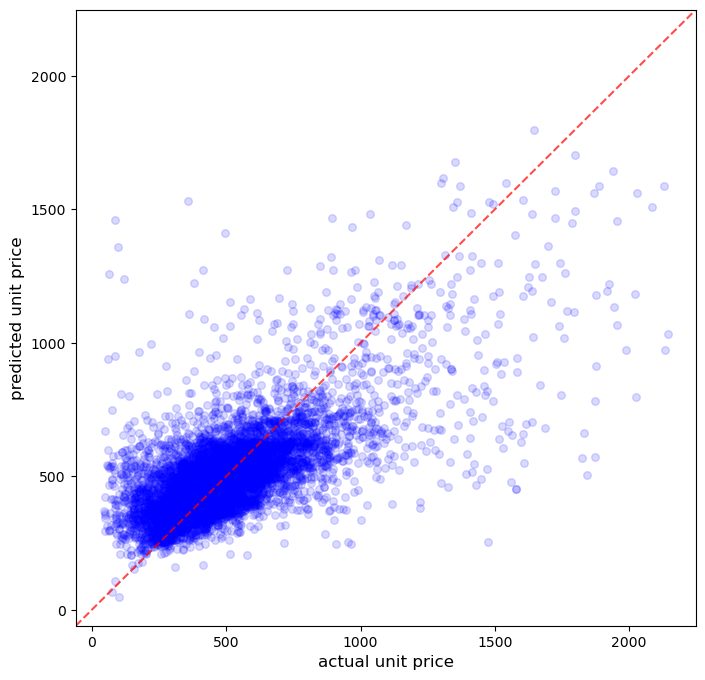

In [124]:
fig,ax = plt.subplots(figsize = (8,8))
plt.scatter(y_test2, y_pred2, s=30, color="blue", label="original", alpha = 0.15)


lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'r--', alpha=0.7, zorder=1)
ax.set_xlabel('actual unit price', fontsize = 12)
ax.set_ylabel('predicted unit price',fontsize =12)
ax.set_xlim(lims)
ax.set_ylim(lims)

Text(0.5, 0, 'TOP 25 Xgboost Feature Importance')

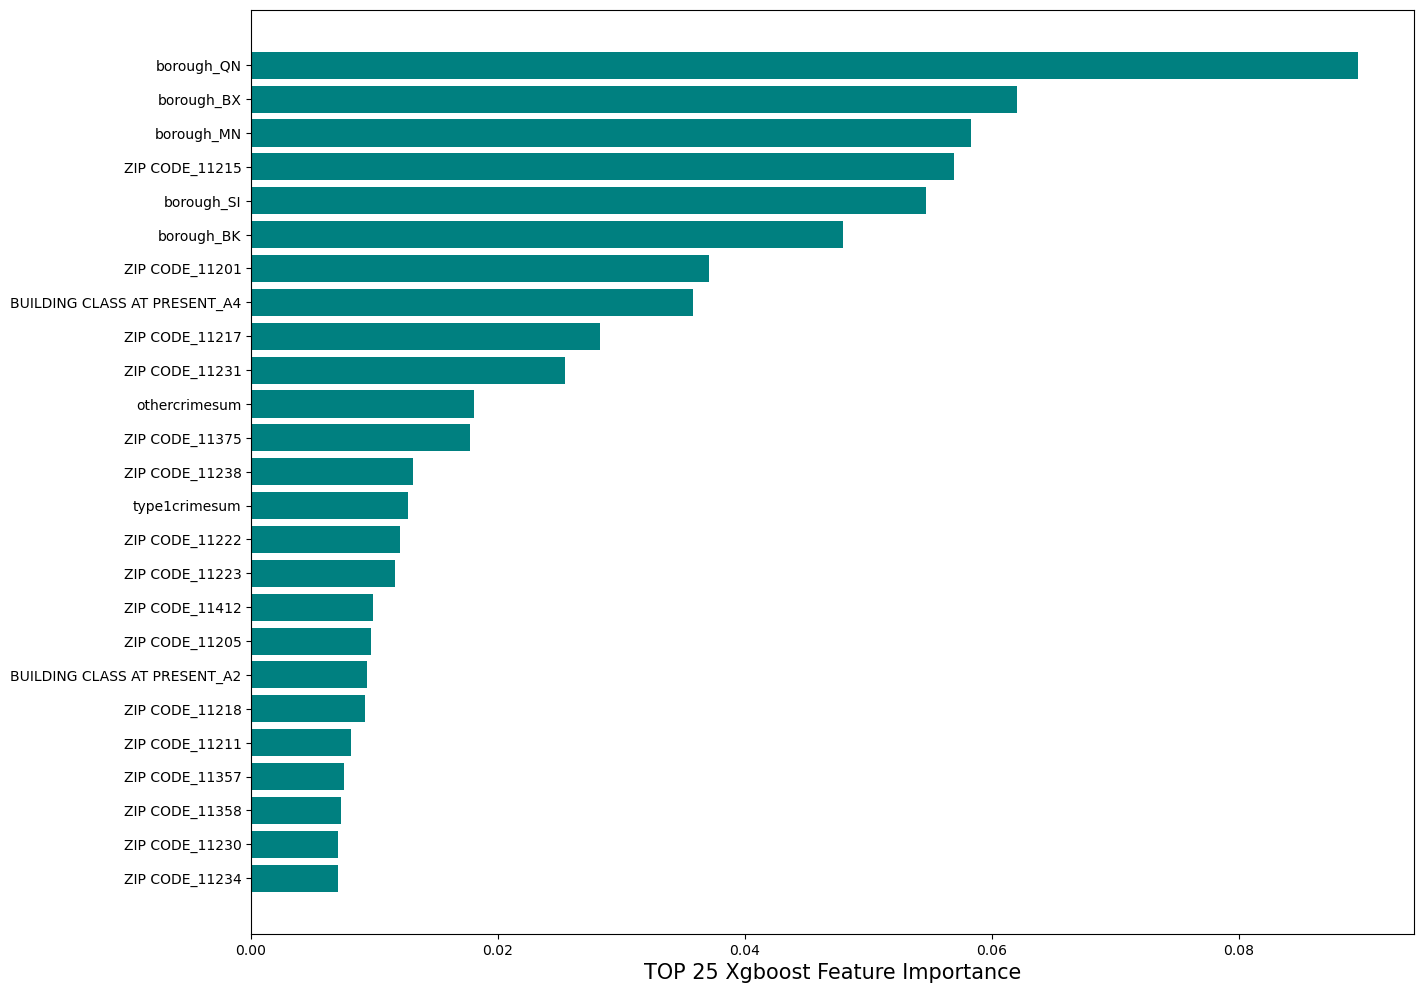

In [138]:
plt.figure(figsize=(15,12))
sorted_idx2 = xgbr2.feature_importances_.argsort()
plt.barh(X2.columns[sorted_idx2][125:], xgbr2.feature_importances_[sorted_idx2][125:], color = 'teal')
plt.xlabel("TOP 25 Xgboost Feature Importance", fontsize = 15)

In [ ]:
# plot trees
# https://machinelearningmastery.com/visualize-gradient-boosting-decision-trees-xgboost-python/

In [ ]:
# https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html#K

In [ ]:
# https://xgboost.readthedocs.io/en/stable/parameter.html#learning-task-parameters
# https://www.kaggle.com/code/prashant111/adaboost-classifier-tutorial/notebook
# https://www.kaggle.com/code/jayatou/xgbregressor-with-gridsearchcv/script
# https://stats.stackexchange.com/questions/110599/how-to-get-both-mse-and-r2-from-a-sklearn-gridsearchcv

In [ ]:
#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/#:~:text=Feature%20Importance%20in%20Gradient%20Boosting&text=Generally%2C%20importance%20provides%20a%20score,the%20higher%20its%20relative%20importance.